In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [18]:
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import warnings
from shapely.geometry import Point
from datetime import timedelta

load_dotenv()
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]
AA_DATA_DIR = Path(os.getenv("AA_DATA_DIR"))

In [3]:
warnings.filterwarnings("ignore")

In [4]:
adm1_path = (
    AA_DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)

gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
ibtracs_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "glb"
    / "ibtracs"
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_ibtracs = gpd.read_file(ibtracs_path)
adm2_path = (
    AA_DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)

gdf_adm2 = gpd.read_file(adm2_path)
gdf_sel_adm2 = gdf_adm2[gdf_adm2.ADM1_PT.isin(ADMS)]

minx, miny, maxx, maxy = gdf_sel.total_bounds

In [45]:
all_storms = [
    "FAVIO",
    "JOKWE",
    "IZILDA",
    "DANDO",
    "IRINA",
    "HARUNA",
    "DELIWE",
    "GUITO",
    "HELLEN",
    "CHEDZA",
    "DINEO",
    "DESMOND",
    "IDAI",
    "KENNETH",
    "CHALANE",
    "ELOISE",
    "GUAMBE",
    "ANA",
    "GOMBE",
    "JASMINE",
    "FREDDY",
    "FILIPO",
]

<Axes: >

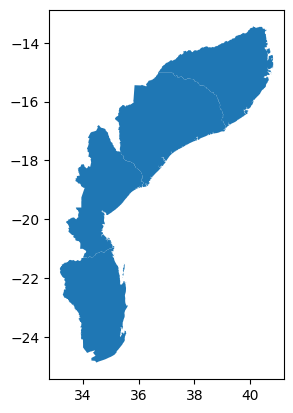

In [22]:
gdf_sel.plot()

In [11]:
landfall_df = pd.read_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed.csv"
)
inam_path = (
    AA_DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "inam"
    / "OCHA_blended_moz"
    / "OCHA_blended_moz"
)

In [12]:
inam_files = files = os.listdir(inam_path)

In [13]:
inam_files[0].split("_")[-1].split(".")[0]

'20030101'

In [14]:
da_in = rxr.open_rasterio(
    inam_path / "chirp_daily_blended_moz_20030101.tif", masked=True
)

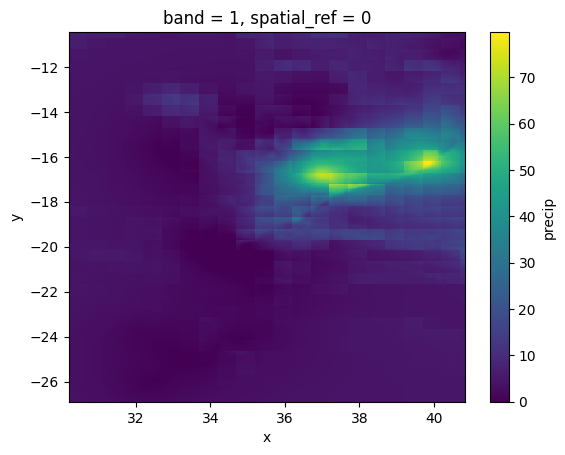

In [15]:
da_in.plot()

In [16]:
# Function to get median rainfall within 250km radius using rioxarray
def get_median_rainfall(tif_path, lon, lat, radius_km, gdf_sel):
    # Open the tif file with rioxarray
    raster = rxr.open_rasterio(tif_path, masked=True).squeeze()

    # Create a circle of 250km radius around the point (lat, lon)
    buffer = Point(lon, lat).buffer(
        radius_km / 110.574
    )  # Roughly 1 degree ~ 110.574 km
    buffer = gdf_sel[gdf_sel.intersects(buffer)].unary_union

    if buffer.is_empty:
        return None

    # Clip the raster using the buffer
    clipped_raster = raster.rio.clip([buffer], gdf_sel.crs, drop=True)

    # Compute the median rainfall within the clipped area
    median_rainfall = np.nanmedian(clipped_raster.values)
    return median_rainfall

In [34]:
# Initialize the output DataFrame
output_df = pd.DataFrame(
    columns=["NAME", "date", "days_to_landfall", "median_rainfall"]
)

# Define the number of days to look around each point's date
days_range = 5  # Adjust this as needed

# Loop through each cyclone (NAME)
for cyclone in landfall_df["NAME"].unique():
    cyclone_df = landfall_df[landfall_df["NAME"] == cyclone].copy()
    cyclone_df["date"] = pd.to_datetime(cyclone_df["date"], dayfirst=True)

    # Find the landfall date (the date when 'actual_within_land' is True)
    landfall_date = cyclone_df[cyclone_df["actual_within_land"]].iloc[0][
        "date"
    ]
    print(cyclone)
    # Process each date for the cyclone
    for index, row in cyclone_df.iterrows():
        # Determine the date range to search for TIF files
        start_date = row["date"] - timedelta(days=days_range)
        end_date = row["date"] + timedelta(days=days_range)
        # Loop through all TIF files in inam_path
        for tif_file in os.listdir(inam_path):
            # Extract date from TIF filename assuming 'chirp_daily_blended_moz_YYYYMMDD.tif' format
            tif_date_str = tif_file.split("_")[-1].split(".")[0]
            tif_date = pd.to_datetime(tif_date_str, format="%Y%m%d")

            # Process the TIF file if its date falls within the desired range
            if start_date <= tif_date <= end_date:
                tif_path = os.path.join(inam_path, tif_file)

                # Compute the median rainfall within the 250km radius
                median_rainfall = get_median_rainfall(
                    tif_path, row["LON"], row["LAT"], 250, gdf_sel
                )

                # Calculate days to landfall
                days_to_landfall = (tif_date - landfall_date).days

                # Create a temporary DataFrame to store the result
                temp_df = pd.DataFrame(
                    {
                        "NAME": [cyclone],
                        "date": [tif_date],  # Use TIF file's date here
                        "days_to_landfall": [
                            days_to_landfall
                        ],  # Calculate days to landfall
                        "median_rainfall": [median_rainfall],
                    }
                )

                # Append the temporary DataFrame to the output DataFrame using pd.concat
                output_df = pd.concat([output_df, temp_df], ignore_index=True)

FAVIO
JOKWE
IZILDA
DANDO
IRINA
HARUNA
DELIWE
HELLEN
DINEO
DESMOND
IDAI 1
IDAI 2
KENNETH
CHALANE
ELOISE
GUAMBE
ANA
GOMBE
JASMINE
FREDDY
FILIPO


In [35]:
output_df

,NAME,date,days_to_landfall,median_rainfall
0,FAVIO,2007-02-23,1,16.2020
1,FAVIO,2007-02-24,2,14.5270
2,FAVIO,2007-02-25,3,32.7340
3,JOKWE,2008-03-09,1,14.8320
4,JOKWE,2008-03-10,2,39.2590
5,JOKWE,2008-03-11,3,3.2400
6,IZILDA,2009-03-30,1,8.0600
7,IZILDA,2009-03-31,2,3.4440
8,IZILDA,2009-04-01,3,1.3920
9,DANDO,2012-01-17,1,37.3720


In [36]:
output_df.to_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "inam_cyclone_landfall_data.csv"
)

In [37]:
output_df = pd.read_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "inam_cyclone_landfall_data.csv"
)

In [38]:
import matplotlib.pyplot as plt

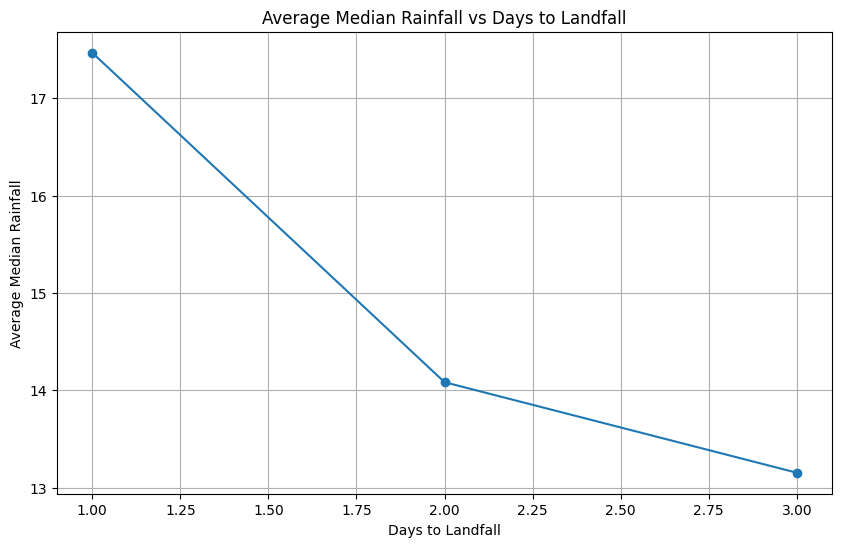

In [39]:
# Group by 'days_to_landfall' and compute the mean of 'median_rainfall'
aggregated_df = output_df.groupby("days_to_landfall", as_index=False).agg(
    {"median_rainfall": "mean"}
)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(
    aggregated_df["days_to_landfall"],
    aggregated_df["median_rainfall"],
    marker="o",
)

# Adding labels and title
plt.xlabel("Days to Landfall")
plt.ylabel("Average Median Rainfall")
plt.title("Average Median Rainfall vs Days to Landfall")
plt.grid(True)

# Show the plot
plt.show()

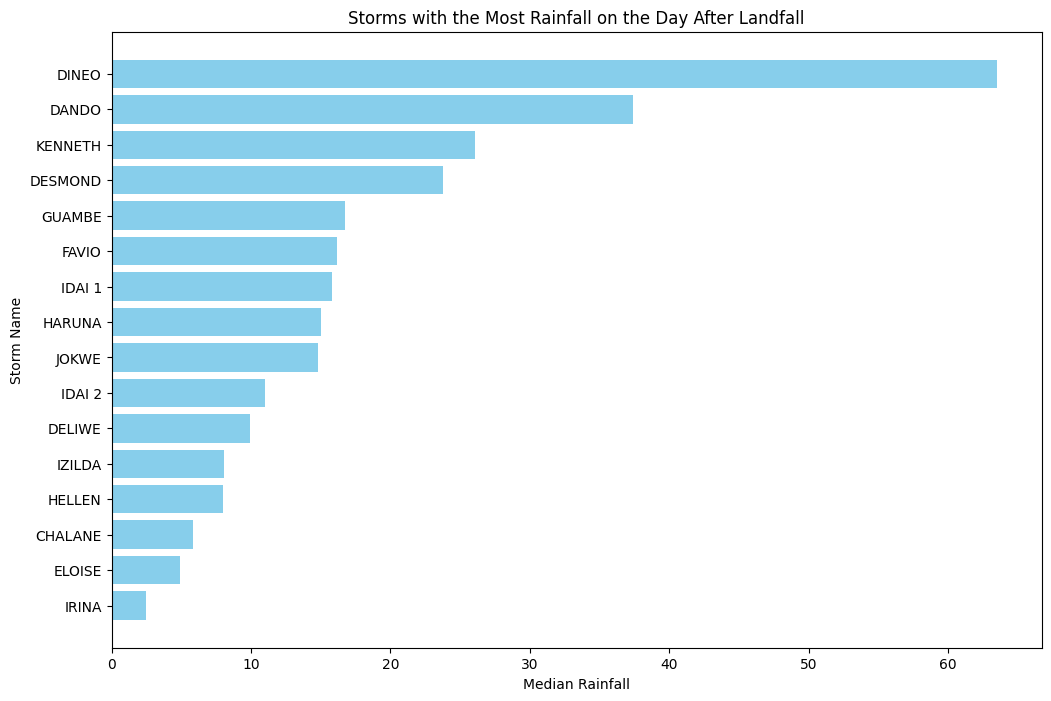

In [40]:
# Filter for records on the day after landfall
day_after_landfall_df = output_df[output_df["days_to_landfall"] == 1]

# Aggregate by storm (NAME) to find the maximum rainfall on the day after landfall
max_rainfall_df = (
    day_after_landfall_df.groupby("NAME")
    .agg({"median_rainfall": "max"})
    .reset_index()
)

# Sort by rainfall in descending order to get storms with the most rainfall
sorted_max_rainfall_df = max_rainfall_df.sort_values(
    by="median_rainfall", ascending=False
)

# Plot the storms with the most rainfall on the day after landfall
plt.figure(figsize=(12, 8))
plt.barh(
    sorted_max_rainfall_df["NAME"],
    sorted_max_rainfall_df["median_rainfall"],
    color="skyblue",
)
plt.xlabel("Median Rainfall")
plt.ylabel("Storm Name")
plt.title("Storms with the Most Rainfall on the Day After Landfall")
plt.gca().invert_yaxis()  # To display the highest values at the top

# Show the plot
plt.show()

In [41]:
sorted_max_rainfall_df

,NAME,median_rainfall
4,DINEO,63.5330
1,DANDO,37.3720
15,KENNETH,26.0490
3,DESMOND,23.8010
7,GUAMBE,16.7630
6,FAVIO,16.2020
10,IDAI 1,15.7810
8,HARUNA,15.0305
14,JOKWE,14.8320
11,IDAI 2,11.0020
